In [998]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import sys
print(sys.maxsize)

9223372036854775807


In [947]:
df = pd.read_stata('/Users/wangjunjie/Desktop/private/比赛-调研-助研/RA/张英广老师/暑假/VIX/Index File on S&P 50-Daily/index file on S&P 50-daily.dta', columns = ['caldt','ewretd','day','month','year'])
df_vix = pd.read_stata('/Users/wangjunjie/Desktop/private/比赛-调研-助研/RA/张英广老师/暑假/VIX/VIXdata/VIXClose_price.dta')

In [948]:
df_vix['vixclose'] = df_vix['vixclose']

# use VIX^2/12 to reply implied variance 
df_vix['im_var'] = (df_vix['vixclose'])**2/12

In [949]:
# 实际上这里需要的是日度数据，这里算的并不准确。下周优化这一部分
# 实际上，以每一天为间隔，需要在日度数据中计算方差，此处算月度方差是非常错误的
# 次数写上是为了之后使用日度数据做一个框架
# 基本趋势符合paper，但是数量级不符合paper
# 实际上计算realized variance还是没有解决！

df['ewretd'] = pd.to_numeric(df['ewretd'], errors = 'coerce')
# we use Cao's paper to construct the RV
df['delta_log_ret'] = (np.log((1 + df['ewretd'])))**2
df['RV'] = df['delta_log_ret'].rolling(30).sum()

count    24825.000000
mean         0.004641
std          0.009500
min          0.000145
25%          0.001023
50%          0.001840
75%          0.003788
max          0.094453
Name: RV, dtype: float64

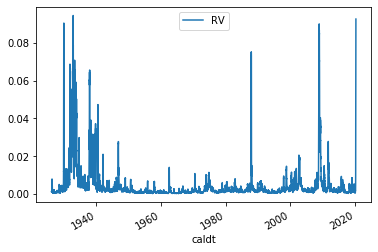

In [982]:
df.plot(x = 'caldt',y = 'RV')
df['L_RV'] = df['RV'].shift(-1)
df['date'] = df['caldt']
df['RV'].describe()

In [983]:
df_reg = pd.merge(df, df_vix, on = ['date'])
df_reg = df_reg[~np.isnan(df_reg['RV'])]
df_reg = df_reg[~np.isnan(df_reg['L_RV'])]
df_reg = df_reg[~np.isnan(df_reg['im_var'])]

In [984]:
# we then use two models to predict RV
# model one: AR(1) model
lrModel = LinearRegression()

x = df_reg[['L_RV']]
y = df_reg[['RV']]

lrModel.fit(x,y)

# alpha
alpha = lrModel.intercept_[0]
print('alpha = ', alpha)
# beta1
beta = lrModel.coef_[0][0]
print('beta = ', beta)
# 残差
predict_value_1 = (alpha + beta*x)

# R_sqr
R_sqr = lrModel.score(x,y)
print('R_sqr = ', R_sqr)

alpha =  3.15659011860649e-05
beta =  0.9895083633865472
R_sqr =  0.9935035835491147


In [985]:
predict_value_1['date'] = df_reg['date'].shift(-1)
predict_value_1['pre_rv_1'] = predict_value_1['L_RV']
predict_value_1 = predict_value_1.drop('L_RV', axis = 1)
predict_value_1['pre_rv_1'].describe()

count    7617.000000
mean        0.004142
std         0.008331
min         0.000205
25%         0.001198
50%         0.002050
75%         0.003874
max         0.091635
Name: pre_rv_1, dtype: float64

In [986]:
# model two: an added model
lrModel = LinearRegression()

x = df_reg[['L_RV','im_var']]
y = df_reg[['RV']]

lrModel.fit(x,y)

# alpha
alpha = lrModel.intercept_[0]
print('alpha = ', alpha)
# beta1
beta_1 = lrModel.coef_[0][0]
print('beta_1 = ', beta_1)
#beta2
beta_2 = lrModel.coef_[0][1]
print('beta_2 = ', beta_2)

# 残差
predict_value_2 = pd.DataFrame(lrModel.predict(x), columns = ['pre_rv_2'])

# R_sqr
R_sqr = lrModel.score(x,y)
print('R_sqr = ', R_sqr)

alpha =  0.0001249793127648096
beta_1 =  1.0103648522717101
beta_2 =  -4.975248916754509e-06
R_sqr =  0.9936328495712017


In [987]:
predict_value_2['date'] = df_reg['date'].shift(-1)
predict_value_2['pre_rv_2'].describe()

count    7617.000000
mean        0.004142
std         0.008331
min         0.000251
25%         0.001214
50%         0.002047
75%         0.003858
max         0.092308
Name: pre_rv_2, dtype: float64

In [988]:
df_f1 = df_reg.merge(predict_value_1, on = ['date'])
df_f2 = df_f1.merge(predict_value_2, on = ['date'])

In [989]:
df_f2

,caldt,ewretd,day,month_x,year_x,delta_log_ret,RV,L_RV,date,vixclose,im_var,year_y,month_y,pre_rv_1,pre_rv_2
0,1990-01-03,-0.002146,3.0,1,1990,0.000005,0.001503,0.001488,1990-01-03,18.190000,27.573008,1990.0,1.0,0.001519,0.001521
1,1990-01-04,-0.006324,4.0,1,1990,0.000040,0.001488,0.001523,1990-01-04,19.220000,30.784033,1990.0,1.0,0.001504,0.001491
2,1990-01-05,-0.005938,5.0,1,1990,0.000035,0.001523,0.001497,1990-01-05,20.110000,33.701008,1990.0,1.0,0.001538,0.001510
3,1990-01-08,0.002367,8.0,1,1990,0.000006,0.001497,0.001597,1990-01-08,20.260000,34.205633,1990.0,1.0,0.001513,0.001470
4,1990-01-09,-0.011740,9.0,1,1990,0.000139,0.001597,0.001614,1990-01-09,22.200000,41.070000,1990.0,1.0,0.001612,0.001568
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7611,2020-03-24,0.117414,24.0,3,2020,0.012325,0.086140,0.087067,2020-03-24,61.669998,316.932390,2020.0,3.0,0.085268,0.086517
7612,2020-03-25,0.031544,25.0,3,2020,0.000965,0.087067,0.090448,2020-03-25,63.950001,340.800216,2020.0,3.0,0.086185,0.089815
7613,2020-03-26,0.060332,26.0,3,2020,0.003432,0.090448,0.091844,2020-03-26,61.000000,310.083333,2020.0,3.0,0.089530,0.091378
7614,2020-03-27,-0.036711,27.0,3,2020,0.001399,0.091844,0.092287,2020-03-27,65.540001,357.957643,2020.0,3.0,0.090912,0.091587


In [990]:
df_f2['VRP_1'] = df_f2['im_var'] - df_f2['pre_rv_1']
df_f2['VRP_2'] = df_f2['im_var'] - df_f2['pre_rv_2']

In [991]:
df_f2.VRP_1.describe()

count    7616.000000
mean       36.188943
std        40.124773
min         6.961375
25%        15.343458
50%        24.750717
75%        42.335196
max       569.741659
Name: VRP_1, dtype: float64

In [992]:
df_f2.VRP_2.describe()

count    7616.000000
mean       36.188931
std        40.124697
min         6.961296
25%        15.343483
50%        24.750388
75%        42.335282
max       569.740750
Name: VRP_2, dtype: float64

VRP_1.png successfully saved.


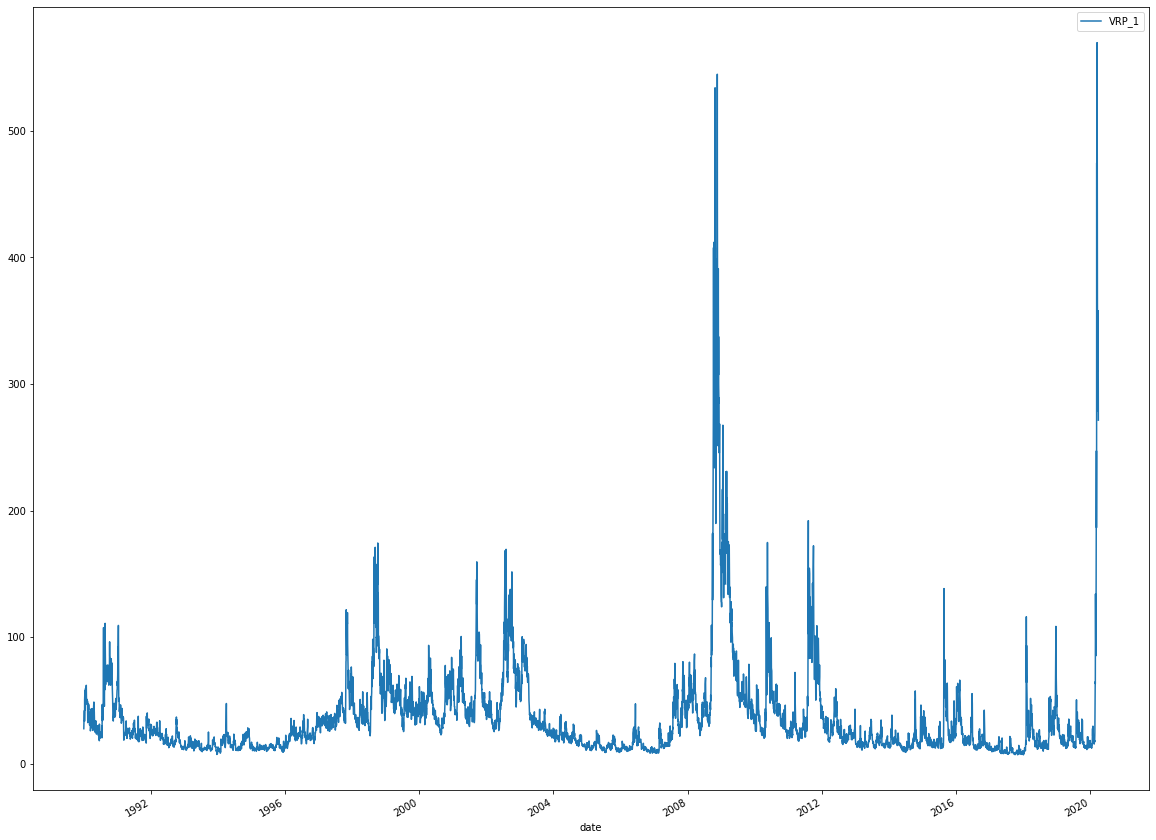

In [993]:
plot = df_f2.plot(figsize = (20,16), y = ['VRP_1'],x = 'date')
plot.get_figure().savefig("VRP_1.png")
print("VRP_1.png successfully saved.")

VRP_2.png successfully saved.


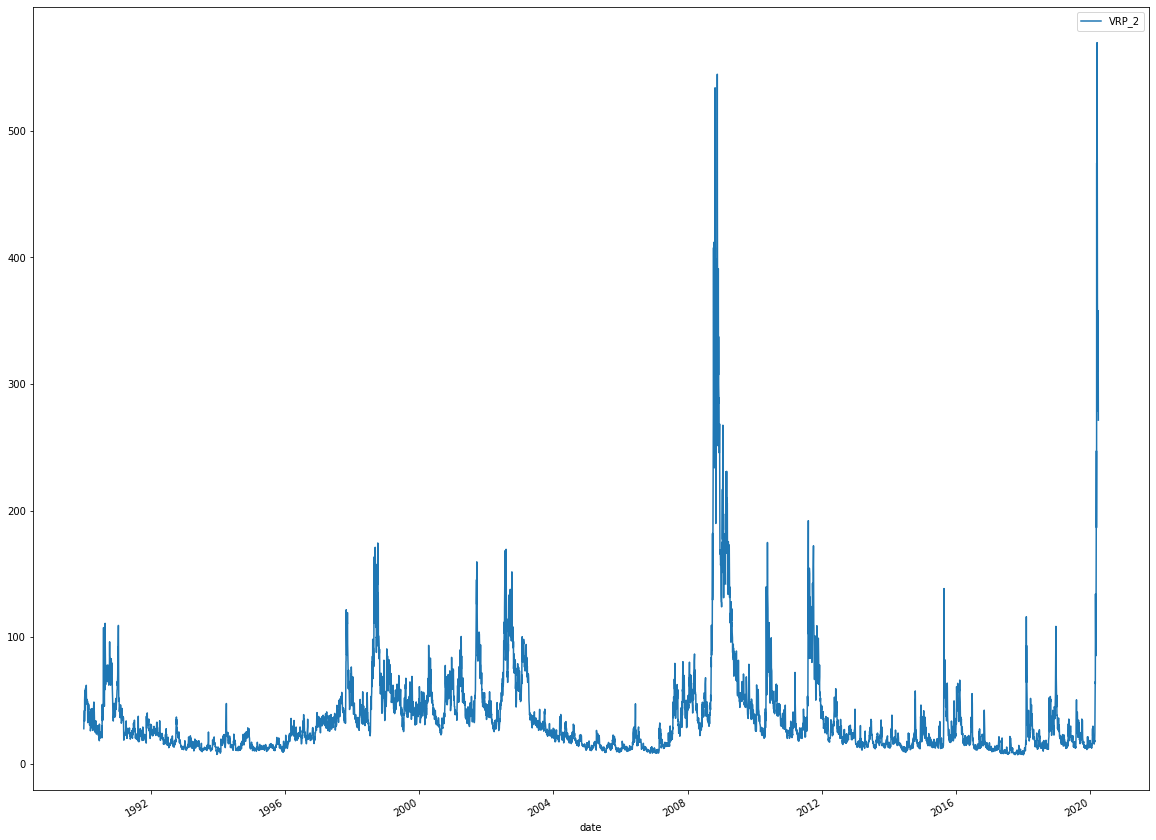

In [994]:
plot = df_f2.plot(figsize = (20,16), y = ['VRP_2'],x = 'date')
plot.get_figure().savefig("VRP_2.png")
print("VRP_2.png successfully saved.")

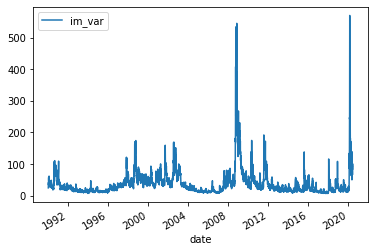

In [995]:
df_vix.plot(x = 'date',y = 'im_var')

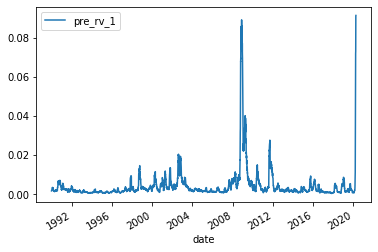

In [996]:
df_f2.plot(x = 'date', y = 'pre_rv_1')

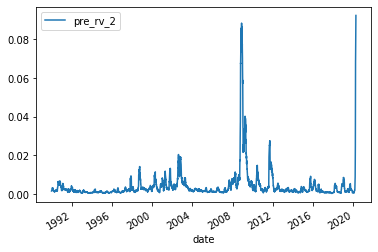

In [997]:
df_f2.plot(x = 'date', y = 'pre_rv_2')